# Analytics

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- Member x
- Member y

### LIBRARIES

In [100]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

from random import randint

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [4]:
jsons = glob('**/*.json') # add the path here
jsons

['complaints/fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-03-05-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-05-05-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-10-05-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-12-04-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-17-04-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-21-04-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-23-03-2021.json',
 'complaints/fga-eps-mds-2020_2-Eccoar_Complaint-27-04-2021.json',
 'front/fga-eps-mds-2020_2-eccoar_frontend-03-05-2021.json',
 'front/fga-eps-mds-2020_2-eccoar_frontend-08-05-2021.json',
 'front/fga-eps-mds-2020_2-eccoar_frontend-10-05-2021.json',
 'front/fga-eps-mds-2020_2-eccoar_frontend-12-04-2021.json',
 'front/fga-eps-mds-2020_2-eccoar_frontend-17-04-2021.json',
 'front/fga-eps-mds-2020_2-eccoar_frontend-21-04-2021.json',
 'front/fga-eps-mds-2020_2-ecco

In [5]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [6]:
base_component_df = create_base_component_df(jsons)

In [7]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
0,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
1,functions,42,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
2,test_execution_time,70,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
3,security_rating,1.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
4,tests,21,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
5,files,19,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
6,complexity,60,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
7,ncloc,626,NaN,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
8,coverage,68.2,False,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
9,reliability_rating,1.0,True,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021


#### Create dataframe per file

In [8]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [9]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"fga-eps-mds-2020_2-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [10]:
file_component_df = create_file_df(jsons)

In [11]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
0,src/migration/1618526567509-CreateComplaint.ts,2,2,0.0,0.0,0.0,76,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
1,src/migration/1618529825437-CreateVote.ts,2,2,0.0,0.0,0.0,38,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
2,src/utils/Category.ts,0,0,0.0,0.0,100.0,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
3,src/entity/Complaint.ts,0,0,0.0,0.0,100.0,36,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
4,src/repositories/ComplaintRepository.ts,7,7,0.0,0.0,61.3,80,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
5,src/utils/ComplaintUpvote.ts,1,3,0.0,0.0,63.6,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
6,src/utils/ComplaintVote.ts,0,0,0.0,0.0,NaN,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
7,src/utils/ComplaintVoteConfirmed.ts,1,3,0.0,0.0,92.3,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
8,src/utils/ComplaintWithVote.ts,0,0,0.0,0.0,NaN,18,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021
9,src/controllers/ControllerComplaint.ts,13,24,0.0,0.0,90.3,170,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Eccoar_Complaint-01-05-2021...,Eccoar_Complaint,01-05-2021


In [12]:
file_component_df.to_excel('data/data.xlsx', index = False)

#### Create dataframe per repository

In [15]:
file_component_df.repository.unique()

array(['Eccoar_Complaint', 'Eccoar_Gateway', 'Eccoar_Mailer',
       'Eccoar_Reports', 'Eccoar_Users', 'eccoar_frontend'], dtype=object)

In [106]:
# Example

eccoar_complaint_df = file_component_df[file_component_df['repository'] == 'Eccoar_Complaint']
eccoar_gateway_df = file_component_df[file_component_df['repository'] == 'Eccoar_Gateway']
eccoar_frontend_df = file_component_df[file_component_df['repository'] == 'eccoar_frontend']
eccoar_reports_df = file_component_df[file_component_df['repository'] == 'Eccoar_Reports']
eccoar_mailer_df = file_component_df[file_component_df['repository'] == 'Eccoar_Mailer']
eccoar_users_df = file_component_df[file_component_df['repository'] == 'Eccoar_Users']
...

Ellipsis

#### Create dataframe per release

In [59]:
release_list = file_component_df[['repository', 'version']].drop_duplicates().values

release_df_list = {}

for release in release_list:
    df = file_component_df.loc[(file_component_df['repository'] == release[0]) & (file_component_df['version'] == release[1])]
    release_df_list[release[0] + '=>' + release[1]] = df

release_df_list.keys()

dict_keys(['Eccoar_Complaint=>01-05-2021', 'Eccoar_Complaint=>03-05-2021', 'Eccoar_Complaint=>05-05-2021', 'Eccoar_Complaint=>10-05-2021', 'Eccoar_Complaint=>12-04-2021', 'Eccoar_Complaint=>17-04-2021', 'Eccoar_Complaint=>21-04-2021', 'Eccoar_Complaint=>23-03-2021', 'Eccoar_Complaint=>27-04-2021', 'Eccoar_Gateway=>01-05-2021', 'Eccoar_Gateway=>03-05-2021', 'Eccoar_Gateway=>05-05-2021', 'Eccoar_Gateway=>10-05-2021', 'Eccoar_Gateway=>12-04-2021', 'Eccoar_Gateway=>17-04-2021', 'Eccoar_Gateway=>23-03-2021', 'Eccoar_Gateway=>23-04-2021', 'Eccoar_Gateway=>28-04-2021', 'Eccoar_Mailer=>03-05-2021', 'Eccoar_Mailer=>12-04-2021', 'Eccoar_Mailer=>17-04-2021', 'Eccoar_Mailer=>22-04-2021', 'Eccoar_Mailer=>23-03-2021', 'Eccoar_Mailer=>23-04-2021', 'Eccoar_Mailer=>27-04-2021', 'Eccoar_Reports=>03-05-2021', 'Eccoar_Reports=>12-04-2021', 'Eccoar_Reports=>17-04-2021', 'Eccoar_Reports=>23-03-2021', 'Eccoar_Reports=>27-04-2021', 'Eccoar_Users=>03-05-2021', 'Eccoar_Users=>08-05-2021', 'Eccoar_Users=>08-05-2

### Metric calculations

##### COMPLEXITY

In [67]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [68]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [69]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

### Calculate m1, m2 and m3 for each repository

In [125]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm7': [ None for i in m1_list],
                               'm8': [ None for i in m1_list],
                               'm9': [ None for i in m1_list],
                               'repository': repository_list, 
                               'version': version_list})
        
    return metrics_df

In [126]:
eccoar_gateway_metrics = create_metrics_df(eccoar_gateway_df)
eccoar_complaint_metrics = create_metrics_df(eccoar_complaint_df)
eccoar_frontend_metrics = create_metrics_df(eccoar_frontend_df)
eccoar_mailer_metrics = create_metrics_df(eccoar_mailer_df)
eccoar_reports_metrics = create_metrics_df(eccoar_reports_df)
eccoar_users_metrics = create_metrics_df(eccoar_users_df)
file_component_metrics = create_metrics_df(file_component_df)

In [127]:
def calculate_ac(df):
    df['asc1'] = (df['m1'] + df['m2'] + df['m3']) / 3
    df['ac1'] = df['asc1']
    df['TOTALac1'] = df['asc1']

    df['asc2'] = (df['m7'] + df['m8'] + df['m9']) / 3
    df['ac2'] = df['asc2']
    df['TOTALac2'] = [ randint(0,10)  for k in df.index]
    return df

In [129]:
eccoar_gateway_metrics = calculate_ac(eccoar_gateway_metrics)
eccoar_complaint_metrics = calculate_ac(eccoar_complaint_metrics)
eccoar_frontend_metrics = calculate_ac(eccoar_frontend_metrics)
eccoar_mailer_metrics = calculate_ac(eccoar_mailer_metrics)
eccoar_reports_metrics = calculate_ac(eccoar_reports_metrics)
eccoar_users_metrics = calculate_ac(eccoar_users_metrics)
file_component_metrics = calculate_ac(file_component_metrics)

,m1,m2,m3,m7,m8,m9,repository,version,asc1,ac1,TOTALac1,asc2,ac2,TOTALac2
0,0.875,0.0,1.0,None,None,None,Eccoar_Gateway,01-05-2021,0.625000,0.625000,0.625000,NaN,NaN,3
1,0.875,0.0,1.0,None,None,None,Eccoar_Gateway,03-05-2021,0.625000,0.625000,0.625000,NaN,NaN,2
2,0.875,0.0,1.0,None,None,None,Eccoar_Gateway,05-05-2021,0.625000,0.625000,0.625000,NaN,NaN,9
3,0.875,0.0,1.0,None,None,None,Eccoar_Gateway,10-05-2021,0.625000,0.625000,0.625000,NaN,NaN,5
4,1.000,0.0,1.0,None,None,None,Eccoar_Gateway,12-04-2021,0.666667,0.666667,0.666667,NaN,NaN,3
5,1.000,0.0,1.0,None,None,None,Eccoar_Gateway,17-04-2021,0.666667,0.666667,0.666667,NaN,NaN,6
6,1.000,0.0,1.0,None,None,None,Eccoar_Gateway,23-03-2021,0.666667,0.666667,0.666667,NaN,NaN,10
7,1.000,0.0,1.0,None,None,None,Eccoar_Gateway,23-04-2021,0.666667,0.666667,0.666667,NaN,NaN,1
8,0.875,0.0,1.0,None,None,None,Eccoar_Gateway,28-04-2021,0.625000,0.625000,0.625000,NaN,NaN,10


In [109]:
def plot_linear_regression(df):
    sns.regplot(x=df["TOTALac1"], y=df["TOTALac2"], line_kws={"color":"r","alpha":0.7,"lw":5})
    plt.show()

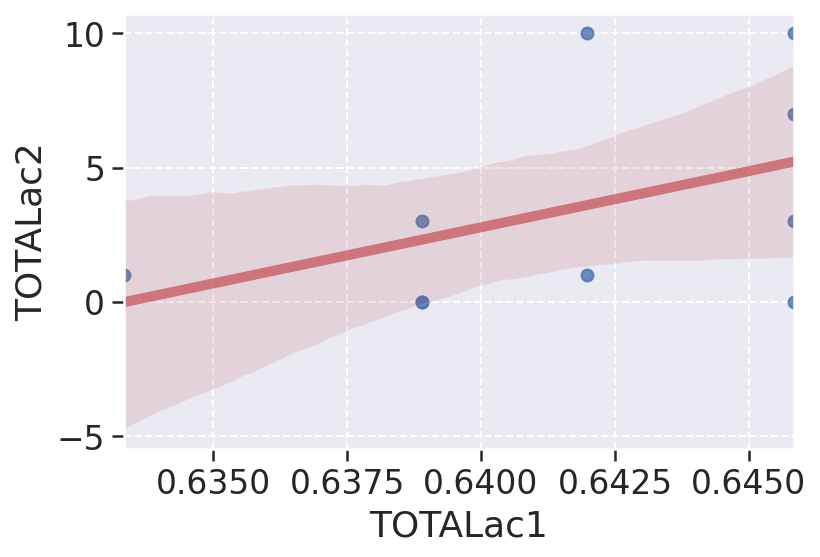

In [131]:
plot_linear_regression(eccoar_frontend_metrics)

### Data visualization

- You must do this for each of your repositories

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo1['m1'], linewidth=3, marker='o', markersize=10)

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo1['m2'], linewidth=3, marker='o', markersize=10)

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo1['m3'], linewidth=3, marker='o', markersize=10)

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo1['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation

- You must do this for each of your repositories

In [ ]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

repo1['asc1'] = ((repo1['m1']*pm1)+(repo1['m2']*pm2)+(repo1['m3']*pm3))*psc1
repo2['asc1'] = ((repo2['m1']*pm1)+(repo2['m2']*pm2)+(repo2['m3']*pm3))*psc1
...

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo1['asc1'], linewidth=3, marker='o', markersize=10)

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot(repo2['asc1'], linewidth=3, marker='o', markersize=10)

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(repo1['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['asc1'], linewidth=3, marker='o', markersize=5)
...

In [ ]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, ...], ignore_index=True)

metrics_df['ac1'] = metrics_df['asc1'] * 1
metrics_df['total'] = metrics_df['asc1'] * 1

In [ ]:
metrics_df

In [ ]:
metrics_df.to_excel('data/metrics_df.xlsx', index = False)